# Time-Series MIA Example 

In [ ]:
import os, sys, yaml, numpy as np, matplotlib.pyplot as plt, torch, pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.time_series_mia.utils.data_preparation import preprocess_dataset, get_dataloaders
from examples.mia.time_series_mia.utils.model_preparation import create_trained_model_and_metadata, evaluate, predict
from examples.mia.time_series_mia.utils.set_seed import set_seed
from examples.mia.time_series_mia.utils.models.LSTM import LSTM
from examples.mia.time_series_mia.utils.models.TCN import TCN
from examples.mia.time_series_mia.utils.models.DLinear import DLinear
from examples.mia.time_series_mia.utils.models.NBeats import NBeats
from examples.mia.time_series_mia.utils.models.WaveNet import WaveNet

from data_handler import IndividualizedInputHandler
from leakpro import LeakPro

In [2]:
audit_config_path = "audit.yaml"
train_config_path = "train_config.yaml"

# Load the yaml files
with open(audit_config_path, 'r') as file:
    audit_config = yaml.safe_load(file)

with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

In [3]:
random_seed = train_config["run"]["random_seed"]
log_dir = train_config["run"]["log_dir"]

epochs = train_config["train"]["epochs"]
batch_size = train_config["train"]["batch_size"]
optimizer = train_config["train"]["optimizer"]

lookback = train_config["data"]["lookback"]
horizon = train_config["data"]["horizon"]
num_individuals = train_config["data"]["num_individuals"]
train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
dataset = train_config["data"]["dataset"]
data_dir = train_config["data"]["data_dir"]
stride = train_config["data"]["stride"]
k_lead = train_config["data"]["k_lead"] # number of leading variables to use

In [4]:
# Get data loaders
path = os.path.join(os.getcwd(), data_dir)
target_data_path = audit_config["target"]["data_path"]
target_data_file = os.path.basename(target_data_path) # Only look at file name of target data path
target_data_file = os.path.splitext(target_data_file)[0]

if target_data_file != dataset:
    raise Exception(f"Received unknown dataset or mismatching target file: dataset={dataset}, target={target_data_path}.")

set_seed(random_seed) # Set seed before and after, to ensure same randomness if you process or dont process dataset (dataset already processed)
dataset = preprocess_dataset(dataset, path, lookback, horizon, num_individuals, k_lead=k_lead, stride=stride)

set_seed(random_seed)
train_loader, test_loader = get_dataloaders(dataset, train_fraction, test_fraction, batch_size=batch_size)

In [5]:
# Train the model
input_dim = dataset.input_dim
model_name = audit_config["target"]["model_class"]

if model_name == "LSTM":
    model = LSTM(input_dim, horizon)
elif model_name == "TCN":
    model = TCN(input_dim, horizon)
elif model_name == "DLinear":
    model = DLinear(input_dim, lookback, horizon)
elif model_name == "NBeats":
    model = NBeats(input_dim, lookback, horizon)
elif model_name == "WaveNet":
    model = WaveNet(input_dim, horizon)
else:
    raise NotImplementedError()

train_loss, test_loss = create_trained_model_and_metadata(model, train_loader, test_loader, epochs, optimizer)

Training Progress: 100%|██████████| 2/2 [00:50<00:00, 25.33s/it]


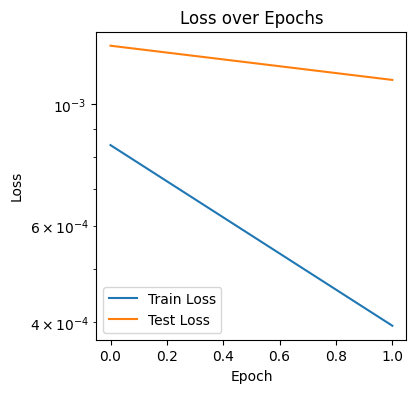

In [6]:
# Plot training and test loss
plt.figure(figsize=(4, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

### Plot metrics for final target model

In [7]:
from examples.mia.time_series_mia.utils.metrics import mse, rmse, nrmse, mae, nd
# Print metrics on final model, unscaled vs scaled, train and test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train = predict(model, train_loader, device, original_scale=False)
test  = predict(model, test_loader, device, original_scale=False)
unscaled_train = predict(model, train_loader, device, original_scale=True)
unscaled_test  = predict(model, test_loader, device, original_scale=True)

metrics, names = [mse, mae, rmse, nrmse, nd], ["MSE", "MAE", "RMSE", "NRMSE", "ND"]
values = [[m(*p) for m in metrics] for p in [train, test, unscaled_train, unscaled_test]]
print(pd.DataFrame(values, columns=names, index=["Train", "Test", "Unscaled train", "Unscaled train"]))

                          MSE         MAE        RMSE     NRMSE        ND
Train                0.000431    0.011579    0.020761  0.147848  0.082460
Test                 0.001108    0.019757    0.033282  0.246567  0.146369
Unscaled train  145425.125000  212.688675  381.346466  0.147848  0.082460
Unscaled train  373735.375000  362.907532  611.338989  0.246567  0.146369


### Plotting sample predictions

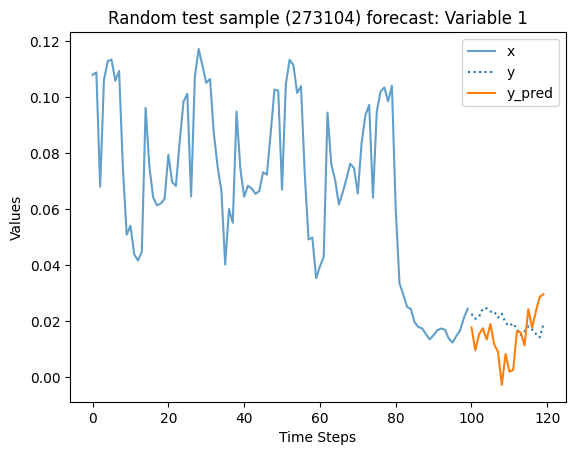

In [8]:
# Get random sample (re-execute for new one)
indices = test_loader.dataset.indices
random_sample_idx = np.random.choice(indices)
x = dataset.x[random_sample_idx,:,:].to(device)
y = dataset.y[random_sample_idx,:,:]
y_pred = model(x.unsqueeze(0)).detach().squeeze(0)

# Time axis
time_x = np.arange(lookback)
time_y = np.arange(lookback, lookback + horizon)

for i in range(y.shape[-1]):  # plot forecast for each variable in the series
    plt.plot(time_x, x[:, i].cpu().numpy(), label='x', alpha=0.7)  # lookback
    plt.plot(time_y, y[:, i], label='y', color='C0', linestyle='dotted')  # true horizon
    plt.plot(time_y, y_pred[:, i].cpu().numpy(), label='y_pred', color='C1')  # prediction

    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    plt.title(f"Random test sample ({random_sample_idx}) forecast: Variable {i+1}")
    plt.show()

### Running MIA

In [ ]:
# Prepare leakpro object
leakpro = LeakPro(IndividualizedInputHandler, audit_config_path)

# Run the audit 
leakpro.run_audit()

{'audit': {'random_seed': 42, 'attack_list': {'ensemble': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_instances': 50, 'subset_size': 50, 'num_pairs': 5, 'audit': True}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'time_series'}, 'target': {'module_path': './utils/models/NBeats.py', 'model_class': 'NBeats', 'target_folder': './target', 'data_path': './data/ELD.pkl'}, 'shadow_model': None, 'distillation_model': None}


2025-03-09 22:38:25,061 INFO     Target model blueprint created from NBeats in ./utils/models/NBeats.py.
2025-03-09 22:38:25,073 INFO     Loaded target model metadata from ./target/model_metadata.pkl
c:\Users\totte\Documents\Kurser\DATX05 - Master's Thesis\LeakPro\leakpro\input_handler\handler_setup.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start sett